In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests
import time

In [ ]:
def mapping_gal_to_intensity(gal):
    if gal == '8gal':
        return '3級'
    if gal == '25gal':
        return '4級'
    if gal == '81gal':
        return '5弱級'
    if gal == '140gal':
        return '5強級'
    if gal == '250gal':
        return '6弱級'
    
def gen_info(df):
    # output info
    result = {}

    true_intensity_level = ['1', '2', '3', '4', '5弱', '5強', '6弱']
    true_intensity_key = ['Label_0.8gal', 'Label_2.5gal', 'Label_8gal', 'Label_25gal', 'Label_81gal', 'Label_140gal', 'Label_250gal']
    pred_intensity_level = ['3', '4', '5弱', '5強', '6弱']
    pred_intensity_key = ['8gal', '25gal', '81gal', '140gal', '250gal']
    
    for data in df.iterrows():
        tmp_station = data[1]['County'] + ' ' + data[1]['Township'] + ' ' + data[1]['Station_Chinese_Name']
        if tmp_station not in result.keys():
            result[tmp_station] = {}

        gt = np.array([data[1][k] for k in true_intensity_key])
        pred = np.array([data[1][k] for k in pred_intensity_key])
        
        
        mask_gt = np.logical_or(gt == '0', gt == '0.0')
        mask_pred = pred == 1

        
        # 檢查真實情況有沒有超過 1 級
        if np.any(mask_gt):
            gt_intensity = mask_gt.tolist().count(False)
            result[tmp_station]['true_intensity'] = true_intensity_level[gt_intensity-1]
        else:
            result[tmp_station]['true_intensity'] = 0

        # 檢查預測情況有沒有超過 1 級
        if np.any(mask_pred):
            prediction_intensity = mask_pred.tolist().count(True)
            result[tmp_station]['pred_intensity'] = pred_intensity_level[prediction_intensity-1]
        else:
            result[tmp_station]['pred_intensity'] = 0

        
        # 計算 leading time
        for idx, p_inten in enumerate(mask_pred):
            if p_inten == False:
                continue
            
            level = true_intensity_key[idx+2]
            pred_time = data[1]['Warning_Time']
            gt_time = data[1][level]
            
            if 'time_diff' not in result[tmp_station]:
                result[tmp_station]['time_diff'] = {}
            
            if gt_time == 0:
                result[tmp_station]['time_diff'][level] = 'false positive'
            else:
                gt_time = datetime.strptime(gt_time, '%Y-%m-%d %H:%M:%S.%f')
                pred_time = datetime.strptime(pred_time, '%Y-%m-%d %H:%M:%S.%f')
                if pred_time < gt_time:
                    time_diff = gt_time - pred_time
                    time_diff = f"提早 {round(time_diff.seconds + time_diff.microseconds/10000 / 100, 2)} 秒"
                else:
                    time_diff = pred_time - gt_time
                    time_diff = f"晚了 {round(time_diff.seconds + time_diff.microseconds/10000 / 100, 2)} 秒"
                    
                result[tmp_station]['time_diff'][level] = time_diff
        
        if(int(str(result[tmp_station]["true_intensity"])[0])>=0 and int(str(result[tmp_station]["pred_intensity"])[0])==0):
            result[tmp_station]['time_diff'] = {}
            for idx, p_inten in enumerate(mask_gt):
                if p_inten == False:
                    continue 
                level = true_intensity_key[idx]
                # result[tmp_station]['time_diff'][level] = 'true negative'
    return result

def send_info(df):
    result = gen_info(df)
    cnt = 0
    msg = ""
    for k, v in result.items():
        msg += f"\n{k} \n預測: {v['pred_intensity']}級, 真實級別: {v['true_intensity']}級\n"
        msg += f"|\t震度\t|\tleading time\t|\n"

        for tmp_k, tmp_v in v['time_diff'].items():
            msg += f"|\t{mapping_gal_to_intensity(tmp_k.split('_')[-1])}\t|\t{tmp_v}\t|\n"

        msg += '=-=-=-=-=-=-=-=-'
        cnt += 1

        # if cnt % 5 == 0:
        #     # alive_notify(msg)
        #     msg = ""

    return msg

# sent the notify proved the system is alive
def alive_notify(msg):
    message = '報告時間: \n' + (datetime.utcfromtimestamp(time.time()) + timedelta(hours=8)).strftime('%Y-%m-%d %H:%M:%S.%f') + '\n'
    message += msg

    token = 'gPDTduLxtElER8j4T2glCQXh3vRJZTtSlKjvhfDaCJb'
    while True:
        try:
            url = "https://notify-api.line.me/api/notify"
            headers = {
                'Authorization': f'Bearer {token}'
            }
            payload = {
                'message': message,
            }
            response = requests.request(
                "POST",
                url,
                headers=headers,
                data=payload,
            )
            if response.status_code == 200:
                print(f"Success, system is alive -> {response.text}")
                break
            else:
                print(f'(Alive) Error -> {response.status_code}, {response.text}')
        except Exception as e:
            print(e)

def output_msg(df_path):
    df = pd.read_csv(df_path)
    true_intensity_key = ['Label_0.8gal', 'Label_2.5gal', 'Label_8gal', 'Label_25gal', 'Label_81gal', 'Label_140gal', 'Label_250gal']
    for key in true_intensity_key:
        df[key] = df[key].fillna(0)
    msg = send_info(df)
    return msg

In [ ]:
msg = output_msg("/home/sora/M11015203/docker-home/Earthworm/pyearthworm-predict-pga25/warning_log/log/2023-5-13-23:57:30_warning.log")
print(msg)

In [ ]:
arr = np.array([0,0,0,0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 6, 6, 6])
diff = np.diff(arr)
indices_0 = np.where(arr == 0)[0]
indices = np.where(diff == 0)[0]

In [ ]:
result = [x for x in indices if x not in indices_0]

## earthworm 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt      # v 3.3.2
import torch
from cala import *
from multi_station_warning.util import *
from dotenv import dotenv_values
import multi_station_warning.models as models
from scipy.stats import norm

In [ ]:
file_list=[f"14062020","14072148","14081049","14111135","14170122","14211101","14222118"]
TP=[0,0,0,0,0]
FP=[0,0,0,0,0]
TN=[0,0,0,0,0]
FN=[0,0,0,0,0]
for file_name in file_list:
    if(file_name !="14081049"):
        continue
    waveform = np.load(f'/home/sora/M11015203/docker-home/Earthworm/pyearthworm-predict-pga25/結果/{file_name}/data/2023-5-20_waveform.npy')
    metadata = np.load(f'/home/sora/M11015203/docker-home/Earthworm/pyearthworm-predict-pga25/結果/{file_name}/data/2023-5-20_metadata.npy')
    positions = np.load(f'/home/sora/M11015203/docker-home/Earthworm/pyearthworm-predict-pga25/結果/{file_name}/data/2023-5-20_position.npy')
    alpha = [0.15,0.60,0.5,0.3,0.3]
    times_pga = np.arange(0.3, 25, 0.5)
    open_index = 500
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env_config = {}
    for k, v in dotenv_values(".env").items():
        env_config[k] = v
        
    #預測要的東西
    pga_thresholds = np.array(env_config["MULTISTATION_THRESHOLDS"].split(','),dtype=np.float32)
    # alpha = np.array(env_config["MULTISTATION_ALPHAS"].split(','),dtype=np.float32)
    model_path = env_config["Multi_Station_CHECKPOINT_FILEPATH"]
    config = json.load(open(os.path.join(env_config["Multi_Station_Config_PATH"]), 'r'))
    model_params = config['model_params'].copy()
    ens_id = 6
    model_params['rotation'] = np.pi / ens_id * 4 / (10 - 1)
    model = models.build_transformer_model(**config['model_params'], device=device, trace_length=3000).to(device)
    model.load_state_dict(torch.load(model_path,map_location=device)['model_weights'], strict=False)
    model.eval()
    pga_times_pre=[] 
    for time in times_pga:
        start_index = int(open_index + time*100)
        # print(start_index)
        sub_waveform = waveform.copy()
        sub_waveform[0,:,:,start_index:] = 0
        for position in positions:
            sub_waveform[0,position,:,:] = slove_convex_wave(torch.Tensor(sub_waveform[0,position,:,:])).cpu()
        input_waveforms = np.transpose(sub_waveform,(0,1,3,2))    
        input_metadata = location_transformation(metadata)
        input_waveforms = torch.Tensor(input_waveforms).to(device)
        input_metadata = torch.Tensor(input_metadata).to(device)
        with torch.no_grad():
            pga_pred = model(input_waveforms,input_metadata).cpu()
        pga_times_pre.append(torch.Tensor(pga_pred))
    pga_times_pre = torch.cat(pga_times_pre,dim=0)
    alpha = torch.Tensor(alpha)
    pga_times_pre_final = np.zeros((pga_pred.shape[1], pga_thresholds.shape[0], 1), dtype=int)
    for j, log_level in enumerate(np.log10(pga_thresholds * 9.81)):
        
        prob = torch.sum(
            pga_times_pre[:, :, :, 0] * (1 - norm.cdf((log_level - pga_times_pre[:, :, :, 1]) / pga_times_pre[:, :, :, 2])),
            dim=-1)
        
        prob = prob.reshape(prob.shape + (1,))
        exceedance = np.array(torch.gt(prob,alpha[j]))  # Shape: times, stations, 1
        exceedance = np.pad(exceedance, ((1, 0), (0, 0), (0, 0)), mode='constant')
        pga_times_pre_final[:, j] = torch.Tensor(np.argmax(exceedance, axis=0))

    pga_times_pre_final -= 1
    pga_times_pred = np.zeros_like(pga_times_pre_final, dtype=float)
    pga_times_pred[pga_times_pre_final == -1] = np.nan
    pga_times_pred[pga_times_pre_final > -1] = times_pga[pga_times_pre_final[pga_times_pre_final > -1]]
    # for time in times_pga:
    #     start_index = int(open_index + time*100)
    #     sub_waveform = waveform.copy()
    #     sub_waveform[0,:,:,start_index:] = 0
    #     for position in positions:
    #         answer = pga_times_pred[position]
    #         sub_waveform[0,position,:,:] = slove_convex_wave(torch.Tensor(sub_waveform[0,position,:,:])).cpu()
    #         color = ['#6A0DAD','#FFC0CB','#0000FF','#90EE90','#FFFF00','#FF0000','#FFA500'] 
    #         pga_threshold = [0.081,0.25,0.81,2.5,8.1,14,25]
    #         hor_acc,_,_,_ = calc_pga(sub_waveform[0,position,0,:],sub_waveform[0,position,1,:], sub_waveform[0,position,2,:], '', 100)
    #         plt.figure(figsize=(20, 10))
    #         plt.subplots_adjust(hspace=0.5)
    #         plt.subplot(511)
    #         plt.plot(sub_waveform[0,position,0,:])
    #         plt.subplot(512)
    #         plt.plot(sub_waveform[0,position,1,:])
    #         plt.subplot(513)
    #         plt.plot(sub_waveform[0,position,2,:])
    #         plt.subplot(514)
    #         #label
    #         plt.plot(hor_acc)
    #         plt.title("Label")
    #         for level in range(len(pga_threshold)):
    #             pga_time = np.argmax(hor_acc > pga_threshold[level]*0.01*9.81)
    #             if (pga_time==0):
    #                 continue
    #             plt.axvline(pga_time,c=color[level],label=f"{pga_threshold[level]}*0.01*9.81")
    #         plt.legend()
    #         #pred
    #         plt.subplot(515)
    #         plt.plot(hor_acc)
    #         pga_threshold = [0.81,2.5,8.1,14,25]
    #         color = ['#0000FF','#90EE90','#FFFF00','#FF0000','#FFA500'] 
    #         for level in range(len(pga_threshold)):
    #             if (np.isnan(answer[level]) or 500+answer[level]*100>start_index):
    #                 continue
    #             plt.axvline(500+answer[level]*100,c=color[level],label=f"{pga_threshold[level]}*0.01*9.81") 
    #         plt.legend()
    #         if not os.path.exists(f'./img_2/{start_index}'):
    #             # If it doesn't exist, create it
    #             os.makedirs(f'./img_2/{start_index}')
    #         plt.savefig(f'./img_2/{start_index}/{position}.png')
    #         plt.clf()
    #         plt.close() 
    
    for position in positions:
        
        answer = pga_times_pred[position]
        color = ['#6A0DAD','#FFC0CB','#0000FF','#90EE90','#FFFF00','#FF0000','#FFA500'] 
        hor_acc,_,_,_ = calc_pga(sub_waveform[0,position,0,:],sub_waveform[0,position,1,:], sub_waveform[0,position,2,:], '', 100)
        plt.figure(figsize=(20, 10))
        plt.subplots_adjust(hspace=0.5)
        plt.subplot(511)
        plt.plot(sub_waveform[0,position,0,:])
        plt.subplot(512)
        plt.plot(sub_waveform[0,position,1,:])
        plt.subplot(513)
        plt.plot(sub_waveform[0,position,2,:])
        plt.subplot(514)
        label
        plt.plot(hor_acc)
        plt.title("Label")
        answer_pga_time = []
        pga_threshold = [0.081,0.25,0.81,2.5,8.1,14,25]
        for level in range(len(pga_threshold)):
            pga_time = np.argmax(hor_acc > pga_threshold[level]*0.01*9.81)
            if (pga_time==0):
                if(level > 1):
                    answer_pga_time.append("nan")
                continue
            if (pga_time<800):
                pga_time=800
            if(level > 1):
                answer_pga_time.append(pga_time)
            plt.axvline(pga_time,c=color[level],label=f"{pga_threshold[level]}*0.01*9.81")
        plt.legend()
        #pred
        plt.subplot(515)
        plt.plot(hor_acc)
        plt.title(f"label:{list(answer_pga_time)},pred:{list(500+answer*100)}")
        pga_threshold = [0.81,2.5,8.1,14,25]
        color = ['#0000FF','#90EE90','#FFFF00','#FF0000','#FFA500'] 
        for level in range(len(pga_threshold)):
            if (np.isnan(answer[level])):
                continue
            plt.axvline(500+answer[level]*100,c=color[level],label=f"{pga_threshold[level]}*0.01*9.81") 
        plt.legend()
        # plt.show()
        if not os.path.exists(f'./img_3/{file_name}'):
            # If it doesn't exist, create it
            os.makedirs(f'./img_3/{file_name}')
        plt.savefig(f'./img_3/{file_name}/{position}.png')
        plt.clf()
        plt.close() 
        #計算成績
        for index in range(len(answer_pga_time)):
            pred = (5+float(answer[index]))*100
            label = answer_pga_time[index]
            if(str(pred) =="nan" and label == "nan"):
                TN[index]+=1
            else:
                if(not str(pred) =="nan" and not label =="nan"):
                    if(pred<label):
                        TP[index]+=1
                    else:
                        FN[index]+=1
                else:
                    if(str(pred) =="nan" and not label =="nan"):
                        FN[index]+=1
                    else:
                        FP[index]+=1  
            # print(f"TP:{TP[index]},TN:{TN[index]},FP:{FP[index]},FN:{FN[index]}")

In [ ]:
print(f"TP:{TP}\nTN:{TN}\nFP:{FP}\nFN:{FN}\n")
for index in range(len(answer_pga_time)):
    try:
        Precision= TP[index]/(TP[index]+FP[index])
        Recall=TP[index]/(TP[index]+FN[index])
        F1_score  = (2*Precision*Recall)/(Precision+Recall)
        print(f"{index}:Precision:{Precision},Recall:{Recall},F1_score:{F1_score}")
    except:
        pass

# 畫圖

In [2]:
import numpy as np
import matplotlib.pyplot as plt      # v 3.3.2
import torch
from cala import *
from multi_station_warning.util import *
from dotenv import dotenv_values
import multi_station_warning.models as models
from scipy.stats import norm

/home/sora/.pyenv/versions/3.8.9/envs/Earthworm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env_config = {}
for k, v in dotenv_values(".env").items():
    env_config[k] = v
#預測要的東西
pga_thresholds = np.array(env_config["MULTISTATION_THRESHOLDS"].split(','),dtype=np.float32)
alpha = [0.15,0.60,0.5,0.8,0.8]
# alpha = np.array(env_config["MULTISTATION_ALPHAS"].split(','),dtype=np.float32)
model_path = env_config["Multi_Station_CHECKPOINT_FILEPATH"]
config = json.load(open(os.path.join(env_config["Multi_Station_Config_PATH"]), 'r'))
model_params = config['model_params'].copy()
ens_id = 6
model_params['rotation'] = np.pi / ens_id * 4 / (10 - 1)
model = models.build_transformer_model(**config['model_params'], device=device, trace_length=3000).to(device)
model.load_state_dict(torch.load(model_path,map_location=device)['model_weights'], strict=False)
model.eval()
pga_times_pre=[] 
times_pga=[]
for index in range(1,40):
    try:
        waveform = np.load(f'./warning_log/data/2023-5-28-14:36:12/{index}_waveform.npy')
        positions = np.load(f'./warning_log/data/2023-5-28-14:36:12/{index}_position.npy')
        metadata = np.load(f'./warning_log/data/2023-5-28-14:36:12/{index}_metadata.npy')
        times_pga.append(index)
    except:
        continue
    input_waveforms = np.transpose(waveform,(0,1,3,2))    
    input_metadata = location_transformation(metadata)
    input_waveforms = torch.Tensor(input_waveforms).to(device)
    input_metadata = torch.Tensor(input_metadata).to(device)
    with torch.no_grad():
        pga_pred = model(input_waveforms,input_metadata).cpu()
        pga_times_pre.append(torch.Tensor(pga_pred))
        
        
pga_times_pre = torch.cat(pga_times_pre,dim=0)
alpha = torch.Tensor(alpha)
pga_times_pre_final = np.zeros((pga_pred.shape[1], pga_thresholds.shape[0], 1), dtype=int)
times_pga = np.array(times_pga)
for j, log_level in enumerate(np.log10(pga_thresholds * 9.81)):
    
    prob = torch.sum(
        pga_times_pre[:, :, :, 0] * (1 - norm.cdf((log_level - pga_times_pre[:, :, :, 1]) / pga_times_pre[:, :, :, 2])),
        dim=-1)
    
    prob = prob.reshape(prob.shape + (1,))
    exceedance = np.array(torch.gt(prob,alpha[j]))  # Shape: times, stations, 1
    exceedance = np.pad(exceedance, ((1, 0), (0, 0), (0, 0)), mode='constant')
    pga_times_pre_final[:, j] = torch.Tensor(np.argmax(exceedance, axis=0))

pga_times_pre_final -= 1
pga_times_pred = np.zeros_like(pga_times_pre_final, dtype=float)
pga_times_pred[pga_times_pre_final == -1] = np.nan
pga_times_pred[pga_times_pre_final > -1] = times_pga[pga_times_pre_final[pga_times_pre_final > -1]]


In [4]:
pga_times_pre = np.zeros((pga_thresholds.shape[0],pga_pred.shape[1]), dtype=int)
for j,log_level in enumerate(np.log10(pga_thresholds * 9.81)):
    prob = torch.sum(
        pga_pred[:, :, :, 0] * (1 - norm.cdf((log_level - pga_pred[:, :, :, 1]) / pga_pred[:, :, :, 2])),
        axis=-1)
    exceedance = np.squeeze(prob > alpha[j])  # Shape: stations, 1
    pga_times_pre[j] = exceedance
    
# #(250,5)
pga_times_pre = np.transpose(pga_times_pre,(1,0))  

In [7]:
for index in range(20,30):
    try:
        waveform = np.load(f'./warning_log/data/2023-5-28-14:36:12/{index}_waveform.npy')
        positions = np.load(f'./warning_log/data/2023-5-28-14:36:12/{index}_position.npy')
        metadata = np.load(f'./warning_log/data/2023-5-28-14:36:12/{index}_metadata.npy')
    except:
        print(f"error")
        continue
    
    for position in positions:
        answer = pga_times_pred[position]
        sub_waveform = waveform.copy()
        # sub_waveform[0,position,:,:] = slove_convex_wave(torch.Tensor(sub_waveform[0,position,:,:])).cpu()
        sub_waveform = waveform[0,position,:,:] - np.mean(waveform[0,position,:,:], axis=-1, keepdims=True)
        sub_waveform = waveform[0,position,:,:] 
        color = ['#6A0DAD','#FFC0CB','#0000FF','#90EE90','#FFFF00','#FF0000','#FFA500'] 
        pga_threshold = [0.081,0.25,0.81,2.5,8.1,14,25]
        hor_acc,_,_,_ = calc_pga(sub_waveform[0],sub_waveform[1], sub_waveform[2], '', 100)
        hor_acc[:100] = np.mean(hor_acc)
        plt.figure(figsize=(20, 10))
        plt.subplots_adjust(hspace=0.5)
        plt.subplot(511)
        plt.plot(sub_waveform[0])
        plt.subplot(512)
        plt.plot(sub_waveform[1])
        plt.subplot(513)
        plt.plot(sub_waveform[2])
        plt.subplot(514)
        #label
        plt.plot(hor_acc)
        plt.title("Label")
        for level in range(len(pga_threshold)):
            pga_time = np.argmax(hor_acc > pga_threshold[level]*0.01*9.81)
            if (pga_time==0):
                continue
            plt.axvline(pga_time,c=color[level],label=f"{pga_threshold[level]}*0.01*9.81")
        plt.legend()
        #pred
        plt.subplot(515)
        plt.plot(hor_acc)
        pga_threshold = [0.81,2.5,8.1,14,25]
        color = ['#0000FF','#90EE90','#FFFF00','#FF0000','#FFA500'] 
        for level in range(len(pga_threshold)):
            if (np.isnan(answer[level]) or 500+answer[level]*100>((index+5)*100)):
                continue
            plt.axvline(1000+answer[level]*100,c=color[level],label=f"{pga_threshold[level]}*0.01*9.81") 
        plt.legend()
        if not os.path.exists(f'./img_2/{index*100}'):
            # If it doesn't exist, create it
            os.makedirs(f'./img_2/{index*100}')
        plt.savefig(f'./img_2/{index*100}/{position}.png')
        plt.clf()
        plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

error
error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

error
error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

error


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

In [15]:

waveform = np.load(f'/home/sora/M11015203/docker-home/Earthworm/pyearthworm-predict-pga25/warning_log/data/2023-5-24_waveform_final.npy')
positions = np.load(f'/home/sora/M11015203/docker-home/Earthworm/pyearthworm-predict-pga25/warning_log/data/2023-5-24_position_final.npy')
metadata = np.load(f'/home/sora/M11015203/docker-home/Earthworm/pyearthworm-predict-pga25/warning_log/data/2023-5-24_metadata_final.npy')
length=4000
for position in positions:
    answer = pga_times_pred[position]
    color = ['#6A0DAD','#FFC0CB','#0000FF','#90EE90','#FFFF00','#FF0000','#FFA500'] 
    
    sub_waveform = waveform[0,position,:,:length] - np.mean(waveform[0,position,:,:length], axis=-1, keepdims=True)
    sub_waveform = waveform[0,position,:,:length] 
    hor_acc,_,_,_ = calc_pga(sub_waveform[0],sub_waveform[1], sub_waveform[2], '', 100)
    plt.figure(figsize=(20, 10))
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(511)
    plt.plot(sub_waveform[0])
    plt.subplot(512)
    plt.plot(sub_waveform[1])
    plt.subplot(513)
    plt.plot(sub_waveform[2])
    plt.subplot(514)
    # label
    plt.plot(hor_acc)
    plt.title("Label")
    answer_pga_time = []
    pga_threshold = [0.081,0.25,0.81,2.5,8.1,14,25]
    for level in range(len(pga_threshold)):
        pga_time = np.argmax(hor_acc > pga_threshold[level]*0.01*9.81)
        if (pga_time==0):
            if(level > 1):
                answer_pga_time.append("nan")
            continue
        # if (pga_time<800):
        #     pga_time=800
        if(level > 1):
            answer_pga_time.append(pga_time)
        plt.axvline(pga_time,c=color[level],label=f"{pga_threshold[level]}*0.01*9.81")
    plt.legend()
    #pred
    plt.subplot(515)
    plt.plot(hor_acc)
    plt.title(f"label:{list(answer_pga_time)},pred:{list(500+answer*100)}")
    pga_threshold = [0.81,2.5,8.1,14,25]
    color = ['#0000FF','#90EE90','#FFFF00','#FF0000','#FFA500'] 
    for level in range(len(pga_threshold)):
        if (np.isnan(answer[level])):
            continue
        plt.axvline(1000+answer[level]*100,c=color[level],label=f"{pga_threshold[level]}*0.01*9.81") 
    plt.legend()
    # plt.show()
    if not os.path.exists(f'./img_3/'):
        # If it doesn't exist, create it
        os.makedirs(f'./img_3/')
    plt.savefig(f'./img_3/{position}.png')
    plt.clf()
    plt.close() 
    #計算成績
    # for index in range(len(answer_pga_time)):
    #     pred = (5+float(answer[index]))*100
    #     label = answer_pga_time[index]
    #     if(str(pred) =="nan" and label == "nan"):
    #         TN[index]+=1
    #     else:
    #         if(not str(pred) =="nan" and not label =="nan"):
    #             if(pred<label):
    #                 TP[index]+=1
    #             else:
    #                 FN[index]+=1
    #         else:
    #             if(str(pred) =="nan" and not label =="nan"):
    #                 FN[index]+=1
    #             else:
    #                 FP[index]+=1  
        # print(f"TP:{TP[index]},TN:{TN[index]},FP:{FP[index]},FN:{FN[index]}")

FileNotFoundError: [Errno 2] No such file or directory: '/home/sora/M11015203/docker-home/Earthworm/pyearthworm-predict-pga25/warning_log/data/2023-5-24_waveform_final.npy'

## 用log檔案畫畫

2023-05-24 03:06:19.012390
start_time_inner:2023-05-24 03:04:39.705010
2023-05-24 03:06:19.012421
start_time_inner:2023-05-24 03:04:39.705010
levels:[1, 1, 0, 0, 0]
level_index:[10207, 10207]


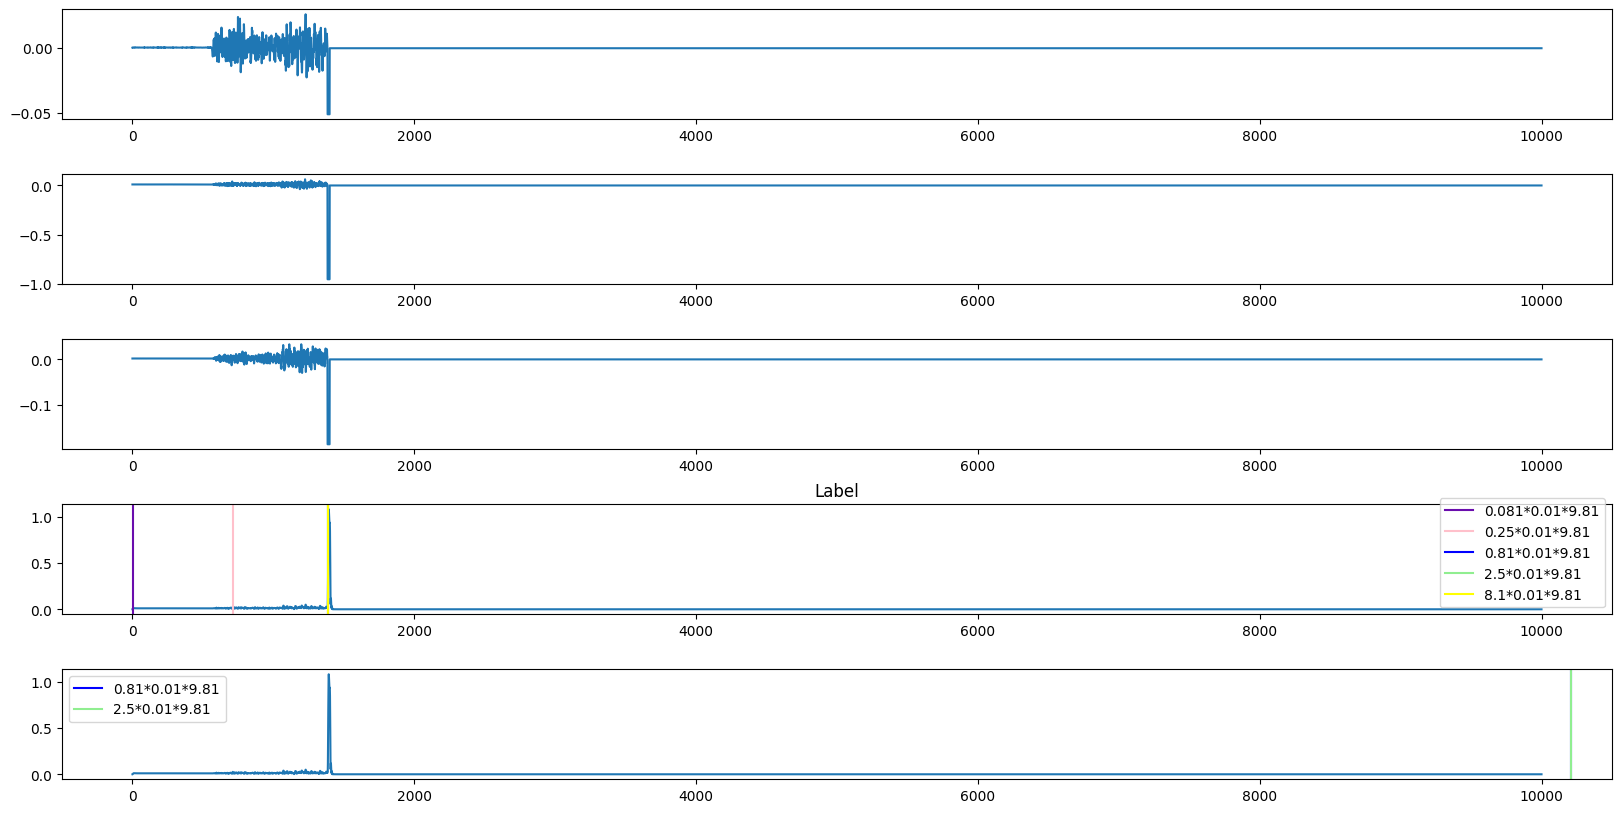

In [58]:
log_name="2023-5-24-3:6:17"
df = pd.read_csv(f"./warning_log/log/{log_name}_warning.log")
waveform = np.load(f'/home/sora/M11015203/docker-home/Earthworm/pyearthworm-predict-pga25/warning_log/data/{log_name}_waveform_final.npy')
positions = np.load(f'/home/sora/M11015203/docker-home/Earthworm/pyearthworm-predict-pga25/warning_log/data/{log_name}_position_final.npy')
metadata = np.load(f'/home/sora/M11015203/docker-home/Earthworm/pyearthworm-predict-pga25/warning_log/data/{log_name}_metadata_final.npy')
gap = 1
length = waveform.shape[3]
# now_time_inner = datetime.utcfromtimestamp(time.time()) +  timedelta(seconds=gap)
now_time_inner = datetime.strptime("2023-05-24 03:06:19.705010","%Y-%m-%d %H:%M:%S.%f")
start_time_inner = now_time_inner -  timedelta(seconds=waveform.shape[3]//100)
for position in positions:
    color = ['#6A0DAD','#FFC0CB','#0000FF','#90EE90','#FFFF00','#FF0000','#FFA500'] 
    sub_waveform = waveform[0,position,:,:length] - np.mean(waveform[0,position,:,:length], axis=-1, keepdims=True)
    sub_waveform = waveform[0,position,:,:length] 
    hor_acc,_,_,_ = calc_pga(sub_waveform[0],sub_waveform[1], sub_waveform[2], '', 100)
    plt.figure(figsize=(20, 10))
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(511)
    plt.plot(sub_waveform[0])
    plt.subplot(512)
    plt.plot(sub_waveform[1])
    plt.subplot(513)
    plt.plot(sub_waveform[2])
    plt.subplot(514)
    # label
    plt.plot(hor_acc)
    plt.title("Label")
    answer_pga_time = []
    pga_threshold = [0.081,0.25,0.81,2.5,8.1,14,25]
    for level in range(len(pga_threshold)):
        pga_time = np.argmax(hor_acc > pga_threshold[level]*0.01*9.81)
        if (pga_time==0):
            continue
        plt.axvline(pga_time,c=color[level],label=f"{pga_threshold[level]}*0.01*9.81")
    plt.legend()
    rows=df[df['Description']==26]
    #pred
    plt.subplot(515)
    plt.plot(hor_acc)
    level_index=[]
    for row in rows.iterrows():
        levels =  [row[1]["8gal"],row[1]["25gal"],row[1]["81gal"],row[1]["140gal"],row[1]["250gal"]]
        print(row[1]["Warning_Time"])
        print(f"start_time_inner:{start_time_inner}")
        index = datetime.strptime(row[1]["Warning_Time"],"%Y-%m-%d %H:%M:%S.%f")-start_time_inner
        level_index.append(index.seconds*100+index.microseconds//1000)
    print(f"levels:{levels}")
    print(f"level_index:{level_index}")
    pga_threshold = [0.81,2.5,8.1,14,25]
    color = ['#0000FF','#90EE90','#FFFF00','#FF0000','#FFA500'] 
    for level in range(len(pga_threshold)):
        if (levels[level]==0):
            break
        plt.axvline(level_index[level],c=color[level],label=f"{pga_threshold[level]}*0.01*9.81") 
    plt.legend()
    plt.show()
    
    break

In [14]:
stations_table_chinese = json.load(open("/home/sora/M11015203/docker-home/Earthworm/pyearthworm-predict-pga25/multi_station_warning/station_name_to_chinese.json", 'r'))
stations_table_chinese[str(0)]

'ESL,花蓮縣,萬榮鄉,西林'

In [10]:
stations_table_coords

{'23.7058,120.2397': 94,
 '23.7047,120.2490': 94,
 '23.7048,120.2491': 94,
 '23.7046,120.2491': 94,
 '23.7192,120.4125': 126,
 '23.7176,120.4204': 126,
 '23.7176,120.4205': 126,
 '23.7168,120.4201': 126,
 '23.7167,120.4202': 126,
 '23.7149,120.5386': 232,
 '23.7149,120.5385': 232,
 '23.5997,120.1795': 94,
 '23.6013,120.1715': 94,
 '23.5996,120.1795': 94,
 '23.6101,120.4214': 126,
 '23.6127,120.4137': 126,
 '23.6101,120.4217': 126,
 '23.6100,120.4217': 126,
 '23.5803,120.5603': 148,
 '23.5815,120.5520': 148,
 '23.5796,120.5601': 148,
 '23.4733,120.1660': 200,
 '23.4840,120.2782': 80,
 '23.4853,120.2692': 80,
 '23.4836,120.2776': 80,
 '23.4728,120.4164': 71,
 '23.4732,120.4083': 71,
 '23.4727,120.4164': 71,
 '23.4630,120.5529': 127,
 '23.4653,120.5440': 127,
 '23.4831,120.6543': 127,
 '23.4837,120.6468': 127,
 '23.4831,120.6544': 127,
 '23.3307,120.1608': 85,
 '23.3328,120.1523': 85,
 '23.3304,120.1597': 85,
 '23.3562,120.2738': 82,
 '23.3572,120.2660': 82,
 '23.3561,120.2738': 82,
 '23.